In [72]:
import pandas as pd
import numpy as np

ratings = pd.read_csv('Data/norm_ratings.csv')
movies_meta_bin = pd.read_csv('Data/movies_meta_bin.csv')

ratings = ratings[ratings['movieId'].isin(movies_meta_bin['movieId'].unique())]
movies_meta_bin = movies_meta_bin[movies_meta_bin['movieId'].isin(ratings['movieId'].unique())]
print('{} ratings, {} movies, {} users'.format(ratings.shape[0], movies_meta_bin.shape[0], ratings['userId'].nunique()))
print(ratings['userId'].unique().tolist())

70167 ratings, 2257 movies, 305 users
[1, 4, 6, 7, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 32, 33, 34, 38, 39, 40, 41, 42, 43, 45, 47, 50, 51, 52, 57, 58, 59, 62, 63, 64, 66, 68, 73, 74, 76, 80, 82, 83, 84, 89, 91, 93, 95, 96, 98, 100, 103, 104, 105, 108, 109, 111, 113, 115, 116, 117, 119, 122, 125, 129, 132, 135, 136, 137, 139, 140, 141, 143, 144, 153, 156, 159, 160, 166, 167, 168, 169, 171, 177, 178, 181, 182, 184, 186, 187, 191, 195, 198, 199, 200, 201, 202, 204, 210, 211, 212, 213, 215, 216, 217, 219, 220, 221, 222, 223, 225, 226, 227, 230, 232, 233, 234, 239, 240, 241, 244, 246, 247, 249, 254, 256, 260, 263, 265, 266, 268, 274, 275, 279, 280, 282, 284, 286, 287, 288, 290, 292, 294, 297, 298, 301, 304, 305, 306, 307, 308, 309, 312, 313, 314, 317, 318, 322, 323, 325, 326, 328, 330, 331, 332, 334, 337, 339, 346, 351, 352, 353, 354, 356, 357, 359, 361, 362, 365, 367, 368, 369, 370, 372, 373, 376, 377, 380, 381, 382, 385, 387, 390, 391, 393, 401, 405, 408, 409, 410, 411

# Create similarity matrices

In [73]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

def meta_similarity(movies_df):


    tf_idf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tf_idf.fit_transform(movies_df['plot'])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    sim_mat = pd.DataFrame(cosine_sim, index=movies_df['movieId'], columns=movies_df['movieId'])
    sim_mat.index.name = 'movieId'
    sim_mat.columns.name = 'movieId'
    return sim_mat


def rating_similarity(ratings_df):
    pvt = pd.pivot_table(ratings, index='userId', columns='movieId', values='rating', fill_value=0)
    rating_sim = pvt.T.corr()
    rating_sim = pd.DataFrame(columns=ratings['userId'].unique(), data=rating_sim, index=ratings['userId'].unique())
    
    rating_sim.index.name = 'userId'
    rating_sim.columns.name ='userId'

    return rating_sim

def meta_user_similarity(ratings_df, movies_df, rating_weighted):
    u = pd.merge(ratings_df, movies_df, on='movieId').drop(columns=['mean', 'title', 'imdbId', 'plot'])
    
    base_columns = ['rating', 'date', 'userId', 'movieId', 'plot']
    content_columns = set(u.columns).difference(base_columns)
    
    if rating_weighted:
        r = np.array(u['rating'])[:, np.newaxis]
        u.loc[:,content_columns] = np.array(u[content_columns]) * r
    
    
    u = u.groupby('userId').sum().drop(columns=['movieId', 'rating'])
    #count = ratings_df.groupby('userId').count()['movieId']
    #u = u.div(count.values, axis=0)
    user_sim = u.reset_index().T.corr()
    user_sim = pd.DataFrame(index=u.index, columns=u.index, data=user_sim)
    
    return user_sim


# To K-Fold, 
movie_sim = meta_similarity(movies_meta_bin)

# To K-Fold, get rid of ratings that are in train set
user_rating_sim = rating_similarity(ratings)
user_weighted_meta_sim = meta_user_similarity(ratings, movies_meta_bin, rating_weighted=True)
user_meta_sim = meta_user_similarity(ratings, movies_meta_bin, rating_weighted=False)
print(movie_sim.shape, user_rating_sim.shape, user_weighted_meta_sim.shape, user_meta_sim.shape)


(2257, 2257) (305, 305) (305, 305) (305, 305)


# Prediction code/algorithm
KNN

In [136]:
def predict_with_user_sim(userId, user_sim_matrix, ratings_df, neighbors= 10):
    if type(userId) == list:
        pred = []
        for u in userId:
            pred.append(predict_with_user_sim(u, user_sim_matrix, ratings_df))
        return pd.concat(pred)
    print(user_sim_matrix)
    u_s_m = user_sim_matrix[userId].drop(userId).sort_values(ascending=False).head(neighbors)
    r = pd.merge(u_s_m, ratings_df, on='userId')
    r['rat_x_sim'] = r['rating'] * r[userId]
    r_summed = r.groupby('movieId').sum().drop(columns=['userId'])
    r_summed['count'] = r.groupby('movieId').count()['userId']
    
    user_mean = ratings_df[ratings_df['userId']==userId]['mean'].iloc[0]

    r_summed['pred_sim'] = ((r_summed['rat_x_sim']) / r_summed[userId]) + user_mean
    r_summed['pred'] = ((r_summed['rating']) / r_summed['count']) + user_mean
    
    r_summed[r_summed['pred_sim'] >5] = 5
    r_summed[r_summed['pred'] >5] = 5
    r_summed[r_summed['pred_sim'] <0] = 0
    r_summed[r_summed['pred'] <0] = 0
    
    r_summed['userId'] = userId
    r_summed = r_summed.rename(columns={userId:'similarity'})
    return r_summed.reset_index()[['movieId','userId','pred','pred_sim', 'count', 'similarity']]

#predict_with_user_sim(184, user_rating_sim, ratings).sort_values(by='pred', ascending=False)

In [104]:
def predict_movie_rating_for_user(movieId, userId, sim, ratings_df):
    rated = ratings[ratings['userId']==userId]

    sims = sim.loc[movieId].drop(movieId).sort_values(ascending=False).reset_index()
    sims = sims[sims['movieId'].isin(rated['movieId'])].head(10)
    sims = pd.merge(sims, rated, on='movieId')
    
    user_mean = rated['mean'].iloc[0]
    sims['rating'] = sims['rating'] + user_mean
    sims['rat_x_sim'] = sims['rating'] * sims[movieId]
    sims = sims.sum()
    return sims['rat_x_sim'] / sims[movieId]
    
def predict_with_movie_sim(userId, sim, ratings_df):
    if type(userId) == list:
        preds = []
        for user in userId:
            preds.append(predict_with_movie_sim(user, sim, ratings))
        return pd.concat(preds)
    
    predictions = pd.DataFrame(data=sim.index, columns=['movieId'])
    predictions['userId'] = userId
    predictions['pred'] = predictions['movieId'].apply(predict_movie_rating_for_user, userId=userId, sim=sim, ratings_df=ratings_df)
    return predictions

#predict_with_movie_sim(1, movie_sim, ratings).sort_values(by='pred', ascending=False)

In [152]:
def get_recommendation(userId, user_sim = user_rating_sim, movie_sim = movie_sim,ratings_= ratings, movies_ = movies_meta_bin):
    if type(userId) == list:
        preds = []
        for user in userId:
            preds.append(get_recommendation(user, user_sim= user_sim, movie_sim = movie_sim, ratings_ = ratings_, movies_ = movies_))
        return pd.concat(preds)
    seen_by_user = ratings_[ratings_['userId']==userId]['movieId']
    pred = predict_with_user_sim(userId, user_sim, ratings_)
    pred = pred[pred['count']>=7]
    #pred = pred[~pred['movieId'].isin(seen_by_user)]
    pred['content_pred'] = pred['movieId'].apply(predict_movie_rating_for_user, userId=userId, sim=movie_sim, ratings_df=ratings)
    pred['avg_pred'] = (pred['pred_sim'] + pred['content_pred'])/2
    pred = pred.sort_values(by='avg_pred', ascending=False)
    return pred[['movieId', 'userId', 'avg_pred', 'count']]

#pred = get_recommendation(1)
#pred

# Evaluation

In [133]:
import seaborn as sns
def get_rmse(prediction, ratings_df):
    merged = pd.merge(ratings, pred, on=['movieId', 'userId'])
    merged['rating'] = merged['rating'] + merged['mean']
    rmse_ = dict()
    for c in ['pred', 'pred_sim']:
        merged['se_'+c] = (merged['rating'] - merged[c])**2
        rmse_[c+'_rmse'] = np.sqrt(merged['se_'+c].mean())
    
    rated_num = ratings_df.groupby('userId').count()['movieId']
    user_rmse = np.sqrt(merged.groupby(by='userId').mean()[['se_pred', 'se_pred_sim']])
    user_rmse['count'] = rated_num
    return merged, rmse_, user_rmse

#_, rmse, user_rmse = get_rmse(pred, ratings)
#user_rmse = user_rmse.sort_values(by='count')
#user_rmse['se_pred_ma'] = user_rmse['se_pred'].rolling(20).mean()
#user_rmse['se_pred_sim_ma'] = user_rmse['se_pred_sim'].rolling(20).mean()

#sns.lineplot(x='count', y='value', hue='variable', data=pd.melt(user_rmse, ['count']))


In [108]:
from sklearn.utils import shuffle
folds = 10

c = ratings.groupby('userId').count()['movieId'].reset_index().rename(columns={'movieId':'total_ratings'})
r = pd.merge(ratings, c, on='userId')
r = shuffle(r)

results = []
result_item = []
result_hybrid = []
u_rmse = []
for k in range(1,folds+1):
    print('Fold {}'.format(k))
    test = r.groupby('userId').head(k*round(r['total_ratings']/folds))
    test = test.groupby('userId').tail(round(test['total_ratings']/folds))
    train = r.drop(index=test.index)
    sim_matrices = [
        ['rating_sim',rating_similarity(train)],
        ['meta_sim_weighted',meta_user_similarity(train, movies_meta_bin, rating_weighted=True)], 
        ['meta_sim',meta_user_similarity(train, movies_meta_bin, rating_weighted=False)]
    ]
    
    m = train['movieId'].unique()
    m = movies_meta_bin[movies_meta_bin['movieId'].isin(m)]
    m_sim = meta_similarity(m)
    
    r = predict_with_movie_sim(test['userId'].unique().tolist(), m_sim, train)
    r = pd.merge(test, r, on=['movieId', 'userId'])
    r = r['rating'] = merged['rating'] + merged['mean']
    r['se'] = (r['rating'] - r['pred']) **2
    result_item.append(np.sqrt(r['se'].sum()))
    
    r = get_recommendation(test['userId'].unique().tolist(), user_sim = sim_matrix[0][1], movie_sim = m_sim,ratings_= train, movies_ = m)
    r = pd.merge(test, r, on=['movieId', 'userId'])
    r = r['rating'] = merged['rating'] + merged['mean']
    r['se'] = (r['rating'] - r['avg_pred']) **2
    result_hybrid.append(np.sqrt(r['se'].sum()))
    
    results_inner = dict()
    for sim_matrix in sim_matrices:
        pred = predict_with_user_sim(test['userId'].unique().tolist() ,sim_matrix[1], train)
        _, rmse, user_rmse= get_rmse(pred, test)
        u_rmse.append(user_rmse)
        results_inner[sim_matrix[0]] = rmse
    results.append(results_inner)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


,rating_sim,meta_sim_weighted,meta_sim
index,,,
pred_rmse,0.833578,1.059117,1.057699
pred_sim_rmse,0.832544,1.062931,1.060096


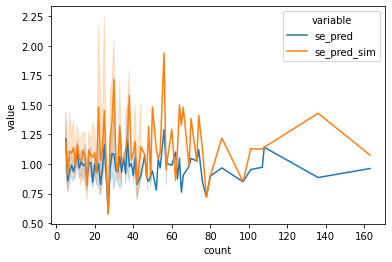

In [109]:
df1 = pd.concat(u_rmse).groupby('userId').mean().sort_values(by='count')
#df1 = df1.rolling(20).mean().dropna()
sns.lineplot(x='count', y='value', hue='variable', data=pd.melt(df1, ['count']))

df = []
for r in results:
    df.append(pd.DataFrame(r))
df = pd.concat(df)
df.reset_index().groupby(by='index').mean()

In [10]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tf_idf.fit_transform(movies_meta_bin['plot'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
plot_sim_mat = pd.DataFrame(cosine_sim, index=movies_meta_bin['movieId'], columns=movies_meta_bin['movieId'])
plot_sim_mat.index.name = 'movieId'
plot_sim_mat.columns.name = 'movieId'

user_rating_sim = rating_similarity(ratings)

In [17]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tf_idf.fit_transform(movies_meta_bin['plot'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
plot_sim_mat = pd.DataFrame(cosine_sim, index=movies_meta_bin['movieId'], columns=movies_meta_bin['movieId'])
plot_sim_mat.index.name = 'movieId'
plot_sim_mat.columns.name = 'movieId'

user_rating_sim = rating_similarity(ratings)

def group_prediction(group, ratings_= ratings, movies_ = movies_meta_bin):

    seen_by_at_least_one = ratings_[ratings_['userId'].isin(group)]['movieId'].unique()
    group_recommendations = get_recommendation(group, ratings_, movies_)
    group_recommendations = group_recommendations[~group_recommendations['movieId'].isin(seen_by_at_least_one)]
    
    group_profile = ratings_[ratings_['userId'].isin(group)]
    group_profile = pd.merge(group_profile, movies_, on='movieId')
    meta_columns = list(set(group_profile.columns.tolist()) - set(['userId', 'movieId', 'rating', 'mean', 'title', 'imdbId', 'date', 'plot']))
    group_profile[meta_columns] = group_profile[meta_columns].mul(group_profile['rating'],axis=0)
    group_profile = group_profile.groupby('userId').sum()[meta_columns]
    group_profile['num_ratings'] = ratings_.groupby('userId').count()['movieId'] 
    
    group_profile[meta_columns] = group_profile[meta_columns].div(group_profile['num_ratings'], axis=0)
    s = group_profile>0.01
    group_likes = []
    for col in meta_columns:
        if(s[col].values.sum()==len(group)):
            group_likes.append(col)
    
    # Least Misery
    if len(group_likes) ==0:
        least_misery = group_recommendations.sort_values(by='avg_pred').groupby('movieId').head(1)
        least_misery = pd.merge(least_misery, movies_, on='movieId')
        least_misery['explanation'] = ''
        for idx, row in least_misery.iterrows():
            least_misery.at[idx, 'explanation'] = 'We recommend watching \'{}\' because no one should dislike it.'.format(row['title'])
        
        return least_misery[['title', 'movieId', 'avg_pred','explanation']].sort_values(by='avg_pred', ascending=False)

    # Add
    options = []
    for col in group_likes:
        options.append(movies_[movies_[col]==1])
    options = pd.concat(options)
    options = options[~options['movieId'].isin(seen_by_at_least_one)]
    times_matched = options.groupby('movieId').count()['imdbId']
    times_matched.name = 'count'
    options = options.drop_duplicates(subset='movieId', keep="last")
    options = pd.merge(options, times_matched, on='movieId')
    options = options[options['count']==options['count'].max()]

    for u in group:
        options[u] = options['movieId'].apply(predict_movie_rating_for_user, userId= u, sim=plot_sim_mat, ratings = ratings_)
        
    options['explanation'] = ''
    for idx, row in options.iterrows():
        s = []
        for l in group_likes:
            if row[l]==1:
                s.append(l)
        s = sorted(s)
        prev = 'ppp'
        exp = 'We recommend watching \'{}\' (imdbId {}) because all group members like'.format(row['title'], row['imdbId'])
        for i in range(len(s)):
            temp = s[i].split('_')
            recent_change = False
            if temp[0]!=prev:
                recent_change = True
                if i!=0:
                    exp+= ' and '
                if temp[0]=='g':
                    exp+= ' genre(s) '
                if temp[0]=='a':
                    exp+=' actor(s) '
                if temp[0]=='d':
                    exp+=' director(s) '
                prev = temp[0]
            if not recent_change and (i==len(s)-1 or not s[i+1].startswith(prev)):
                exp+= ' and '
            elif i!=0 and s[i-1].startswith(prev):
                exp+= ', '
            exp+= temp[1]
        options.at[idx,'explanation']= exp+' and this movie is expected to be enjoyed by all.'

    options['mean_rating'] = options[group].mean(axis=1)
    return options[['title', 'movieId', 'mean_rating','explanation']].sort_values(by='mean_rating', ascending=False)
    

    # 1, 2, 5
sim_group = user_rating_sim.iloc[3].sort_values(ascending=False).head(4)
sim_group = sim_group.index.tolist()

random_group = ratings['userId'].sample(n=5).tolist()

recommendations = group_prediction(random_group)
for idx, row in recommendations.iterrows():
    print(row['explanation'],row['mean_rating'])
    print()

We recommend watching '48 hrs. ' (imdbId 83511) because all group members like genre(s) crime and drama and this movie is expected to be enjoyed by all. 4.078294170649645

We recommend watching 'hamlet ' (imdbId 116477) because all group members like genre(s) crime and drama and this movie is expected to be enjoyed by all. 4.053164145011673

We recommend watching 'chicago ' (imdbId 299658) because all group members like genre(s) crime and drama and this movie is expected to be enjoyed by all. 4.05212836460643

We recommend watching 'once were warriors ' (imdbId 110729) because all group members like genre(s) crime and drama and this movie is expected to be enjoyed by all. 4.02888613417535

We recommend watching 'road to perdition ' (imdbId 257044) because all group members like genre(s) crime and drama and this movie is expected to be enjoyed by all. 4.002811015760168

We recommend watching 'angels & demons ' (imdbId 808151) because all group members like genre(s) crime and drama and t

In [66]:
print(user_rating_sim.min().min())
print(user_rating_sim.max().max())
print(user_rating_sim.mean().mean())

-0.23063612169077388
1.0
0.03114373913345649
